# Introduction
This project aims to automate zooplankton classification using geometric and environmental features. Zooplankton are vital indicators of lake ecosystem health, serving as a crucial link in the food web by feeding on phytoplankton and becoming a food source for fish.

Fishing in Ontario's lakes has a significant economic impact. According to Ontario News (https://news.ontario.ca/en/release/1005496/ontario-boosting-its-fish-populations), more than 1.5 million anglers contribute $1.6 billion annually to the economy.


# Data
I used data from the Ministry of Natural Resources and Forestry, Ontario. The dataset consists of .tif mosaics containing zooplankton images, along with geometric and environmental features. For example, each plankton image includes attributes such as transparency, symmetry, latitude, and longitude.

The classification model will use the "Class" column, focusing on classifying seven classes: Calanoid_1, Cyclopoid_1, Bosmina_1, Harpacticoida, Chironomid, Chydoridae, and Daphnia.

The data comes from two lakes in Ontario: Lake Huron and Lake Simcoe. However, the dataset is highly imbalanced, and some geometric features and labels may be missing.

# Methods
## Data processing
Before applying classification models, I merged all available data from Lake Simcoe for training and testing.

As shown in the graph below, the "TooSmall" class accounts for 51.25% of the dataset. Since this class provides no meaningful information about plankton (as these samples were too small to classify), I decided to exclude them to prevent introducing significant noise into the model.

Since many features are heavily right-skewed, I applied a log transformation to positively skewed data. Additionally, I performed standardization since most features have a large range.

The covariance matrix revealed some highly correlated features, which could lead to multicollinearity. To address this, I used Principal Component Analysis (PCA) with seven principal components. The number of components was determined using the elbow point from the scree plot, as shown in the graph below.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

feature_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Symmetry", 
    "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", 
    "Fiber.Straightness", "Roughness", "Transparency", "Sum.Intensity", "Intensity", 
    "Sigma.Intensity", "Edge.Gradient"
]
target_col = "Class"

# Plot the distribution of classes
class_counts = df[target_col].value_counts()

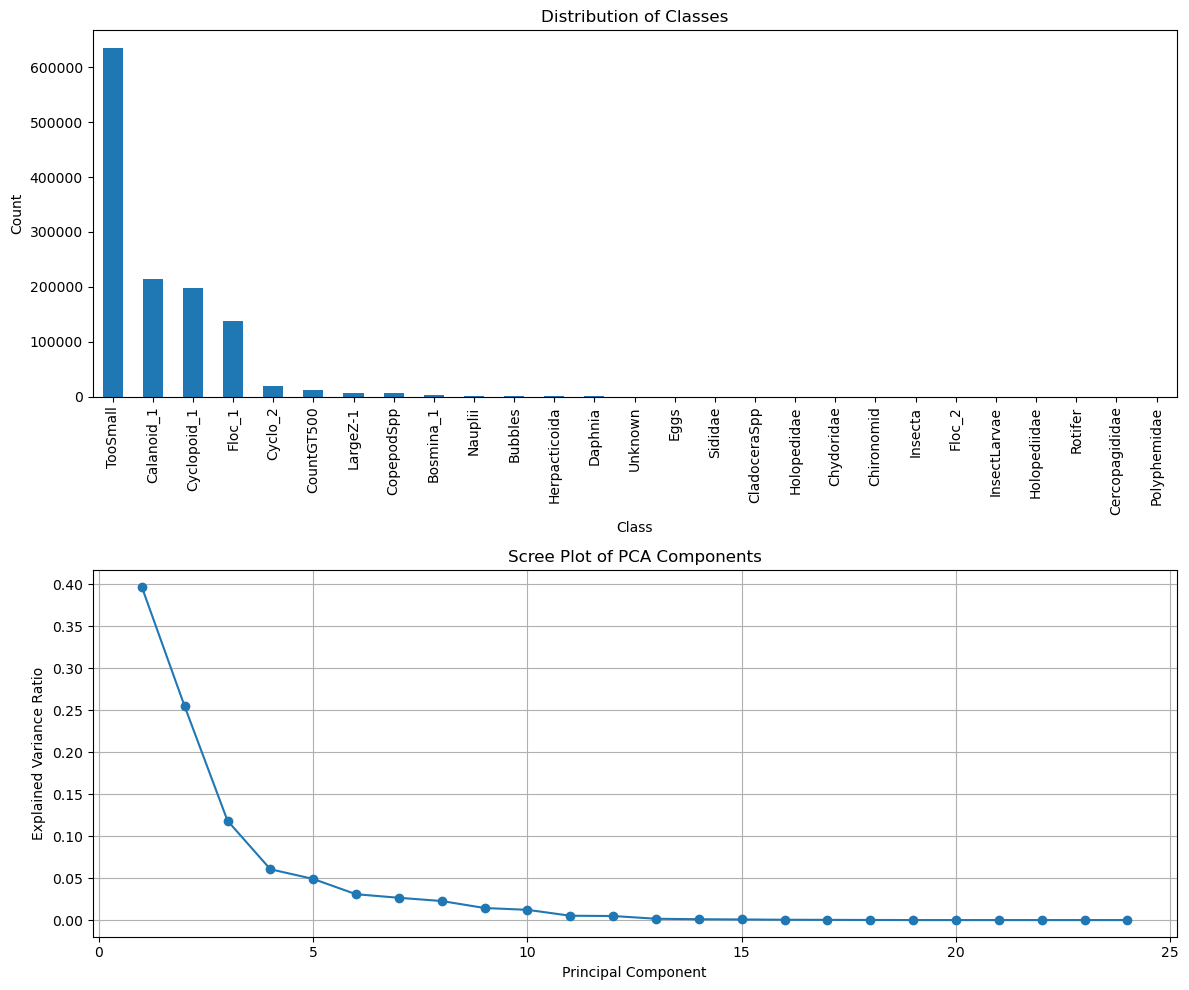

In [19]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = df[df[target_col] != 'TooSmall']

X = df[feature_cols]
y = df[target_col]

# columns with right-skewed distribution
log_transform_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Compactness", "Elongation", "Fiber.Curl", 
    "Roughness", "Sum.Intensity"
]

# log transform
X.loc[:, log_transform_cols] = X[log_transform_cols].apply(lambda x: np.log1p(x))

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# scree plot
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Distribution of classes
class_counts.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Classes')

# Scree plot
axes[1].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('Scree Plot of PCA Components')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Models
I will test various statistical and machine learning models, including logistic regression, XGBoost, and random forest.

The goal is to classify the seven plankton classes of interest while also identifying "Others" for plankton outside this list. One approach to achieving this is hierarchical classification. This involves training a binary classifier to differentiate Known vs. Others, and if a sample is classified as Known, a second classifier predicts the specific plankton type. Therefore there will be three steps for models, which are train model for binary classification, train model for multiclass classification, and combine them. Eventually we split dataset into two. First we need to split the dataset into two, one will be used to train binary and multiclass model and the other will be used to test with combined model of binary and multiclass. To do this, we can avoid data double dipping. However, I decided to use same data for binary and multiclass training since we have fully independent test set for combined model testing. 

### Logistic Regression 

Logistic regression requires several assumptions:

1. Linearly Separable Features: Zooplankton features are not linearly separable, but I will use logistic regression as a baseline due to its simplicity, interpretability, and ability to handle imbalanced classes.

2. No Multicollinearity: Since some features are highly correlated, I applied PCA as part of exploratory data analysis (EDA). The scree plot analysis suggested using seven principal components.

3. Standardized Features: Since feature ranges vary significantly, I standardized all features.

The binary classifier performed well, with high precision and recall for identifying Known plankton. However, it struggled with Others, indicating that some misclassifications occurred. 
The multi-class classification results reveal severe misclassification for some species (Chironomid, Chydoridae, Daphnia, and Herpacticoida), likely due to the extreme class imbalance.
The hierarchical approach marginally improved the recall of Others and balanced class performance slightly. However, some species remain difficult to classify due to extreme class imbalance.
Since logistic regression has clear limitations, I will explore XGBoost and random forest next to handle class imbalance and non-linear relationships better.

In [5]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

known_classes = ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"]

# Known=1, Others=0
df["Known_vs_Others"] = df[target_col].apply(lambda x: 1 if x in known_classes else 0)

# Split dataset for logistic regression training and testing hierarchically
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_pca, df["Known_vs_Others"], test_size=0.2, stratify=df["Known_vs_Others"], random_state=2453
)

# Split dataset for binary classifier training and testing
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=2453)

# Binary Classifier
clf_binary = LogisticRegression()
clf_binary.fit(X_train_binary, y_train_binary)

y_pred = clf_binary.predict(X_test_binary)
print("Binary Classifier Performance:")
print(classification_report(y_test_binary, y_pred))


Binary Classifier Performance:
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     29907
           1       0.86      0.99      0.92     66771

    accuracy                           0.88     96678
   macro avg       0.91      0.82      0.85     96678
weighted avg       0.89      0.88      0.87     96678



In [6]:
# Select known classes only
known_train_mask = (y_train_full == 1)
X_known = X_train_full[known_train_mask]
y_known = df.loc[y_train_full.index[known_train_mask], target_col]

# Split dataset for multiclass classifier training and testing
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X_known, y_known, test_size=0.2, random_state=2453, stratify=y_known
)

# Multiclass Classifier
clf_multiclass = LogisticRegression(class_weight="balanced", max_iter=1000)
clf_multiclass.fit(X_train_multiclass, y_train_multiclass)

y_known_pred = clf_multiclass.predict(X_test_multiclass)
print("Multi Class Classifier Performance:")
print(classification_report(y_test_multiclass, y_known_pred))

Multi Class Classifier Performance:
               precision    recall  f1-score   support

    Bosmina_1       0.32      0.89      0.47       457
   Calanoid_1       0.88      0.52      0.66     34469
   Chironomid       0.00      0.83      0.00         6
   Chydoridae       0.00      0.00      0.00         7
  Cyclopoid_1       0.77      0.57      0.66     31646
      Daphnia       0.02      0.67      0.03        88
Herpacticoida       0.01      0.61      0.02        98

     accuracy                           0.55     66771
    macro avg       0.29      0.59      0.26     66771
 weighted avg       0.82      0.55      0.65     66771



In [ ]:
class HierarchicalClassifier:
    def __init__(self, binary_model=None, multiclass_model=None):
        """
        Initializes the Hierarchical Classifier.
        - binary_model: Model to classify Known vs. Others (default: Logistic Regression)
        - multiclass_model: Model to classify Known classes (default: Logistic Regression)
        """
        self.binary_model = binary_model or LogisticRegression(max_iter=1000)
        self.multiclass_model = multiclass_model or LogisticRegression(class_weight="balanced", max_iter=1000)
        self.is_fitted = False  # Track if the model has been trained
    
    def fit(self, X_train, y_train, X_train_multiclass, y_train_multiclass):
        """
        Trains both binary and multiclass classifiers.
        """
        # print("Training Binary Classifier...")
        self.binary_model.fit(X_train, y_train)
        
        # print("Training Multiclass Classifier...")
        self.multiclass_model.fit(X_train_multiclass, y_train_multiclass)
        
        self.is_fitted = True  # Model is now trained
        # print("Training Complete.")

    def predict(self, X_test):
        """
        Predicts labels using the hierarchical pipeline.
        - First, applies the binary classifier.
        - If classified as "Known", applies the multiclass classifier.
        """
        if not self.is_fitted:
            raise ValueError("Model is not trained. Call `.fit()` first.")
        
        # print("Making Predictions...")
        binary_preds = self.binary_model.predict(X_test)
        
        final_predictions = np.full_like(binary_preds, fill_value="Other", dtype=object)  # Default to "Other"
        known_mask = (binary_preds == 1)  # Identify Known samples
        
        if np.any(known_mask):  # Only predict multiclass if there are Known samples
            final_predictions[known_mask] = self.multiclass_model.predict(X_test[known_mask])
        
        return final_predictions
    
    def evaluate(self, X_test, y_test, y_test_multiclass):
        """
        Evaluates the model using classification reports.
        """
        y_pred = self.predict(X_test)

        # Map ground truth correctly
        y_test_mapped = np.where(y_test == 1, y_test_multiclass, "Other")

        print("Final Hierarchical Classification Performance:")
        print(classification_report(y_test_mapped, y_pred))

In [21]:
model = HierarchicalClassifier()

# Train both models
model.fit(
    X_train_binary, y_train_binary,  # Binary classifier
    X_train_multiclass, y_train_multiclass  # Multiclass classifier
)

y_pred = model.predict(X_test_full)

model.evaluate(X_test_full, y_test_full, df.loc[y_test_full.index, target_col])

Final Hierarchical Classification Performance:
               precision    recall  f1-score   support

    Bosmina_1       0.22      0.89      0.36       592
   Calanoid_1       0.79      0.51      0.62     42869
   Chironomid       0.00      0.71      0.00         7
   Chydoridae       0.00      0.33      0.00         9
  Cyclopoid_1       0.67      0.57      0.62     39750
      Daphnia       0.01      0.53      0.02       118
Herpacticoida       0.01      0.62      0.01       118
        Other       0.96      0.65      0.77     37384

     accuracy                           0.58    120847
    macro avg       0.33      0.60      0.30    120847
 weighted avg       0.80      0.58      0.66    120847



### XGBoost 
XGBoost is well-suited for this dataset because it does not require strict distributional assumptions, can handle missing values, and performs well with imbalanced data.

### Random Forest

Random forest is another suitable model since it can handle high-dimensional and correlated features without requiring assumptions about the data distribution.

# Result
I expect logistic regression to have the lowest accuracy, while XGBoost and random forest should perform similarly, outperforming logistic regression.

# Conclusion